In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd  
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict,train_test_split    

from sklearn.model_selection import cross_val_predict, KFold ,RandomizedSearchCV  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  
from sklearn.linear_model import LinearRegression  
from xgboost import XGBRegressor  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

import shap
shap.initjs()  #如果没有导入将不能正常可视化

In [4]:
# 读取CSV文件  
data = pd.read_csv('/kaggle/input/a241105/a1105.csv')  

In [5]:
data

,Cmcent,Cr,Me,Ei,Ai,Ac,Li,Gy,Ct,Mpa
0,120,20,0.0,0,312.0,0.3,156.0,21,3,2.0
1,120,20,78.0,25,234.0,0.3,156.0,21,3,5.2
2,120,20,156.0,50,156.0,0.3,156.0,21,3,8.6
3,120,20,234.0,75,78.0,0.3,156.0,21,3,7.4
4,120,20,312.0,100,0.0,0.3,156.0,21,3,7.9
...,...,...,...,...,...,...,...,...,...,...
315,489,80,0.0,0,73.0,0.1,36.5,12,90,39.4
316,489,80,18.0,25,55.0,0.1,36.5,12,90,40.0
317,489,80,36.5,50,36.5,0.1,36.5,12,90,42.2
318,489,80,55.0,75,18.0,0.1,36.5,12,90,46.3


In [6]:
data.dropna(inplace=True)
data.columns=['Cmcent','Cr','Me','Ei','Ai','Ac','Li','Gy','Ct','Mpa']
X = data.loc[:,['Cmcent','Cr','Me','Ei','Ai','Ac','Li','Gy','Ct']]
y = data.loc[:,['Mpa']]

**1.绘制特征的相关性热图**  

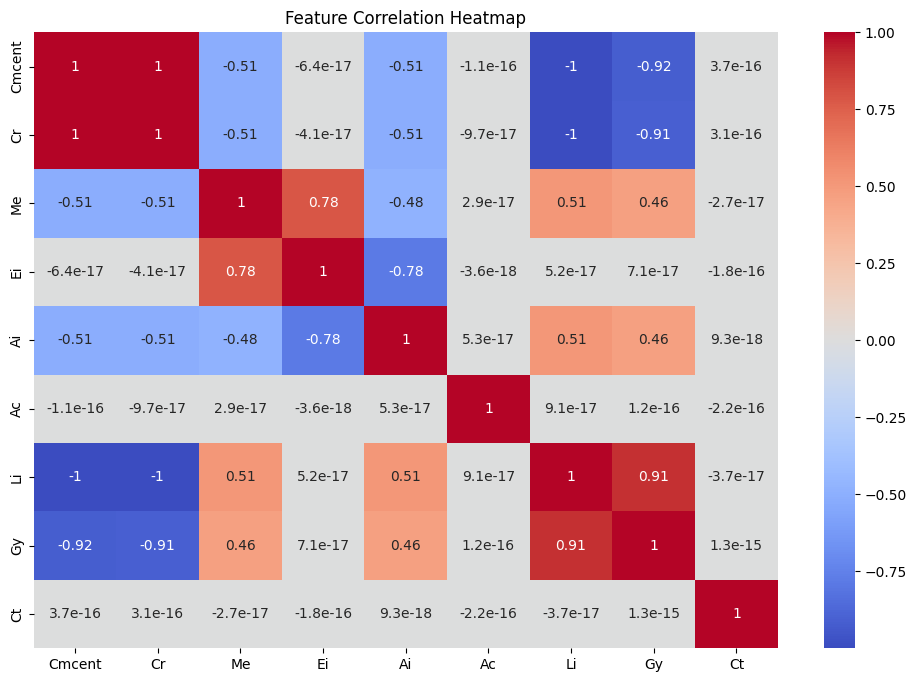

In [6]:
# 绘制特征的相关性热图  
plt.figure(figsize=(12, 8))  
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')  
plt.title('Feature Correlation Heatmap')  
plt.show()  

**2 绘制箱型图**

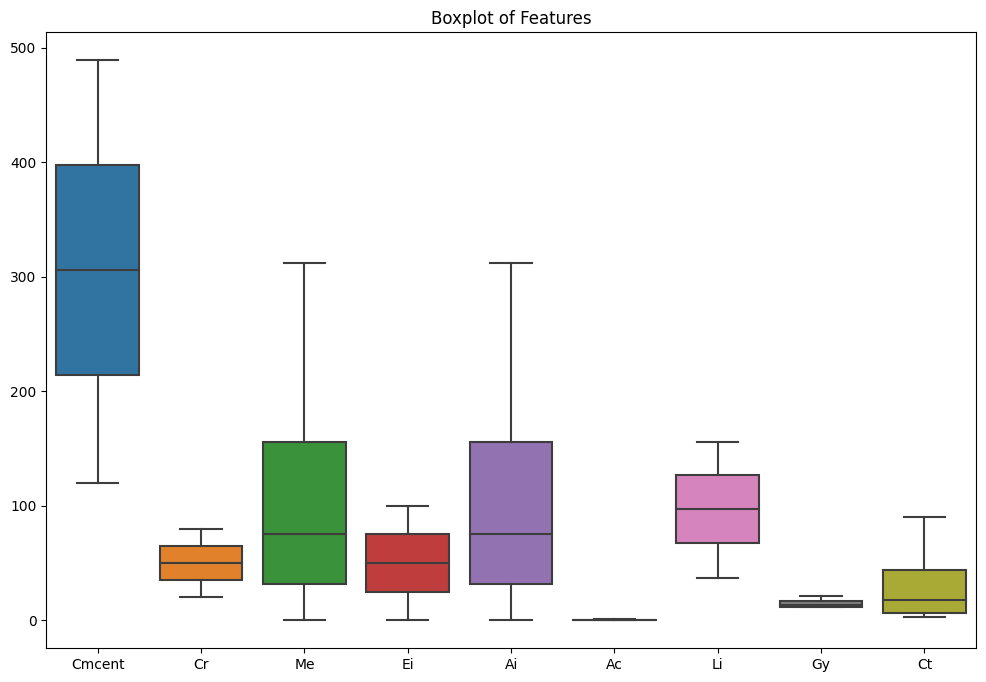

In [8]:
# 使用seaborn绘制箱型图
plt.figure(figsize=(12, 8))
sns.boxplot(data=X, orient="v")   #h水平绘图，v垂直绘图
plt.title('Boxplot of Features')
plt.show()

**3 绘制特征分布直方图**

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

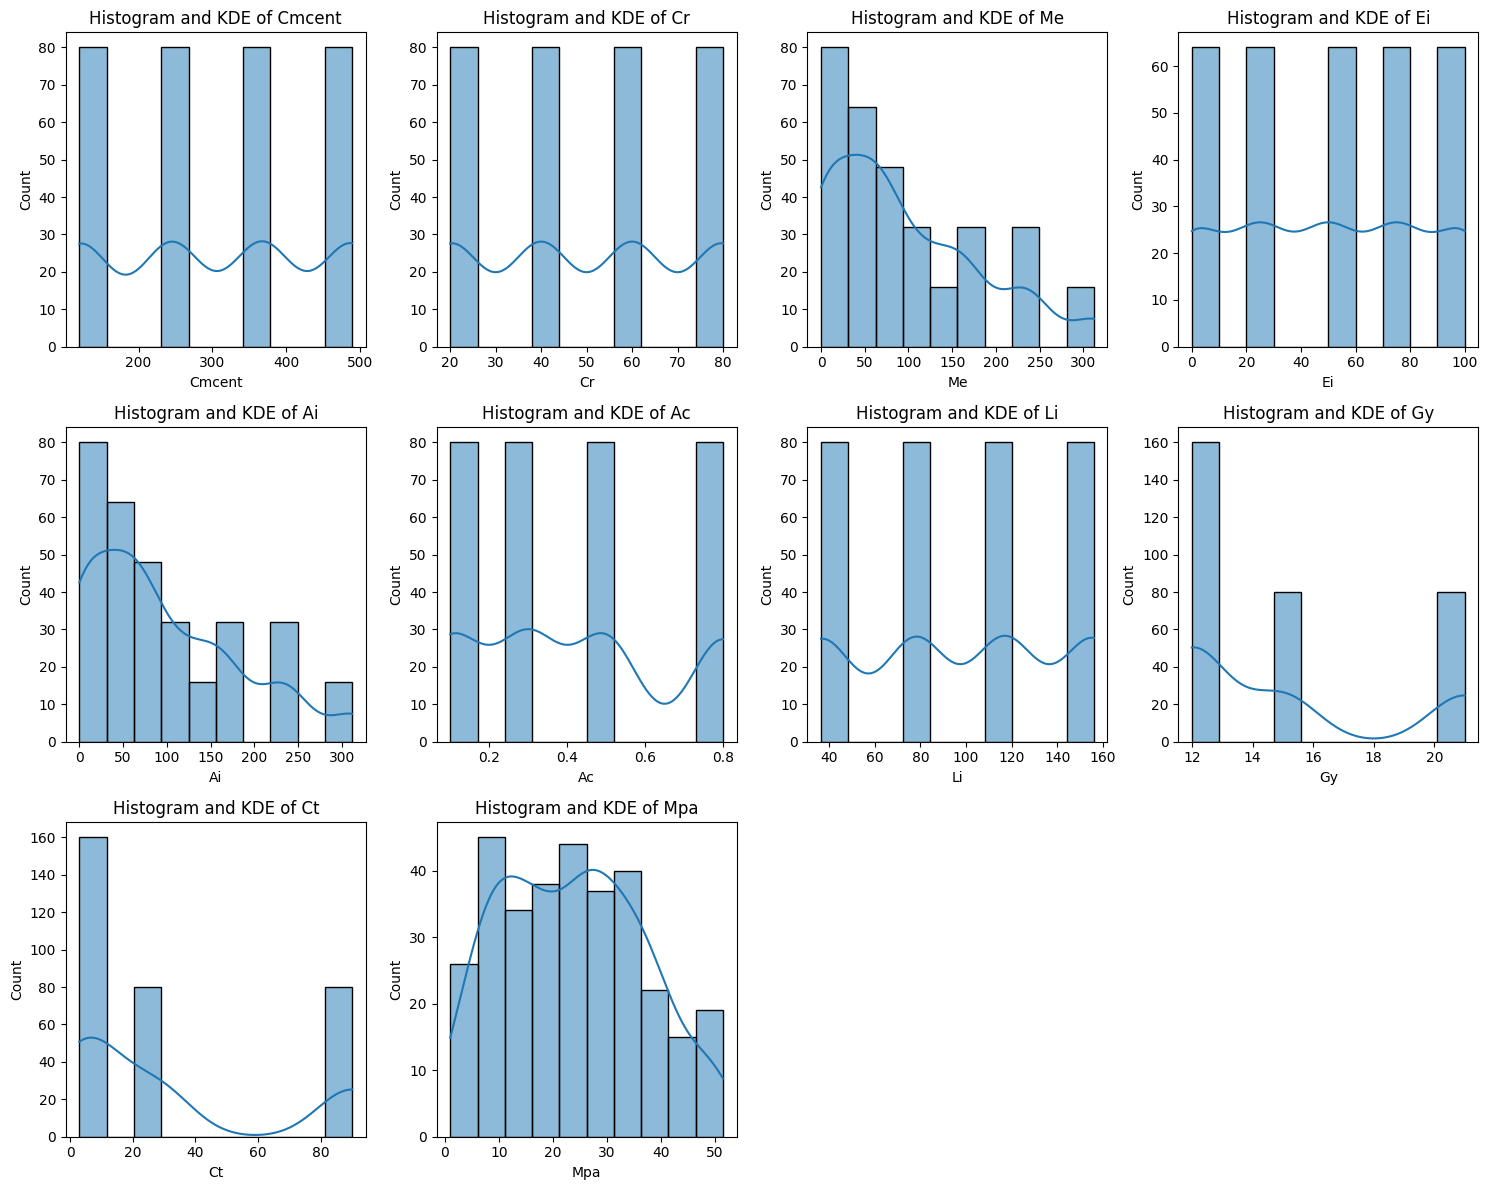

In [9]:
# 设置图形的大小
plt.figure(figsize=(15, 12))
 
# 遍历所有的列，包括特征列和标签列
for i, column in enumerate(data.columns):
    # 在子图上绘制直方图并拟合曲线
    plt.subplot(3, 4, i + 1)  # 3行4列的子图布局
    sns.histplot(data[column], kde=True)  # kde=True表示拟合曲线
    plt.title(f'Histogram and KDE of {column}')  # 设置子图的标题
 
# 调整子图之间的间距
plt.tight_layout()
 
# 显示图形
plt.show()

In [9]:
y.mean()

Mpa    23.634687
dtype: float64

In [10]:
# 定义交叉验证  
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

**4 使用随机网格搜索进行超参数调节**

In [11]:
# 定义随机森林回归器的参数空间
param_distributions = {
    'n_estimators': randint(100, 500),  # 森林中的树木数量
    'max_depth': randint(10, 50),  # 树的最大深度，或者使用None表示不限深度（但这需要单独处理）
    'min_samples_split': randint(2, 20),  # 节点划分最少样本数
    'min_samples_leaf': randint(1, 20),  # 叶节点最少样本数
    'max_features': ['auto', 'sqrt', 'log2', None],  # 寻找最佳划分时要考虑的特征数量
    'bootstrap': [True, False],  # 构建树时是否使用样本放回抽样
    'oob_score': [True, False],  # 是否使用袋外样本来评估模型的泛化精度（仅在bootstrap=True时有效）
    'n_jobs': [-1],  # 并行运行的作业数，-1表示使用所有处理器
    'random_state': [42],  # 随机数生成器的种子，确保结果的可重复性
    'verbose': [0],  # 是否显示构建过程中的详细信息，0表示不显示
}
 
# 创建随机森林回归器实例
rf = RandomForestRegressor()
 
# 创建RandomizedSearchCV实例
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=kf, scoring='neg_mean_squared_error', random_state=888)
 
# 对数据进行随机搜索和交叉验证
random_search.fit(X, y.values.ravel())  # 注意y需要是一维数组
 
# 输出最佳参数组合
print("Best parameters found: ", random_search.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters found:  {'bootstrap': True, 'max_depth': 18, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 338, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0}


In [18]:
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100,          # 树的数量，通常越多越好，但计算成本也更高
        max_depth=10,              # 树的最大深度，控制过拟合
        min_samples_split=2,       # 节点划分最少样本数
        min_samples_leaf=1,        # 叶子节点最少样本数
        max_features='auto',       # 寻找最佳划分时要考虑的特征数量
        random_state=42            # 随机数生成器的种子，确保结果可重复
    ),
    'SVR': SVR(
        C=1.0,                     # 正则化参数，C越大，正则化越弱
        epsilon=0.1,               # 误差容忍度，控制模型的复杂度和准确性之间的平衡
        kernel='rbf',              # 核函数类型，'rbf'表示径向基函数
        gamma='scale',             # 核函数的系数，'scale'表示使用1 / (n_features * X.var())作为gamma的值
    ),
    'LinearRegression': LinearRegression(
        fit_intercept=True,        # 是否计算截距项
        copy_X=True,               # 是否复制X，如果False，会覆盖输入数据
        n_jobs=None                # 使用的CPU核数量，None表示使用所有可用的核
    ),
    'XGBRegressor': XGBRegressor(
        objective='reg:squarederror',  # 目标函数，这里是平方误差
        n_estimators=100,              # 树的数量
        learning_rate=0.1,             # 学习率
        max_depth=3,                   # 树的最大深度
        min_child_weight=1,            # 叶子节点最小权重和
        subsample=0.8,                 # 子样本比例
        colsample_bytree=0.8,          # 每棵树随机采样特征的比例
        gamma=0,                       # 损失函数减少的最小值
        reg_alpha=0,                   # L1正则化项
        reg_lambda=1,                  # L2正则化项
        random_state=42                # 随机数生成器的种子
    )
}

# 存储每个新模型的评估指标
results = {}
 
# 对每个新模型进行交叉验证并计算评估指标
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 交叉验证设置
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X, y.values.ravel(), cv=kf)
    errors = y.values.ravel() - y_pred  # 计算预测误差
    mse = mean_squared_error(y.values.ravel(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y.values.ravel(), y_pred)
    # 计算 MAPE 需要确保 y 不包含零值
    mape = np.mean(np.abs(errors / y.values.ravel())) * 100
    r2 = r2_score(y.values.ravel(), y_pred)
    std_deviation = np.std(errors)  # 计算预测误差的标准差
    
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Std Deviation': std_deviation  # 添加标准差到结果字典中
    }
 
# 打印新模型的结果
print("Results for models:")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.4f}%")
    print(f"R2: {metrics['R2']:.4f}")
    print(f"Std Deviation: {metrics['Std Deviation']:.4f}")  # 打印标准差
    print()

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Results for models:
Model: RandomForest
MSE: 4.6347
RMSE: 2.1528
MAE: 1.5082
MAPE: 9.2088%
R2: 0.9727
Std Deviation: 2.1498

Model: SVR
MSE: 33.4786
RMSE: 5.7861
MAE: 4.5244
MAPE: 28.4804%
R2: 0.8029
Std Deviation: 5.7677

Model: LinearRegression
MSE: 22.4198
RMSE: 4.7350
MAE: 3.7291
MAPE: 27.9117%
R2: 0.8680
Std Deviation: 4.7349

Model: XGBRegressor
MSE: 3.8855
RMSE: 1.9712
MAE: 1.4567
MAPE: 9.3080%
R2: 0.9771
Std Deviation: 1.9707



**5 使用线性回归模拟经验公式**|

In [34]:
y = y.squeeze()  #先把标签列（dataframe）转化为一维数组，一维数组是一个连续的线性序列，没有行和列的概念
 
# 创建线性回归模型
model = LinearRegression(fit_intercept=True)
 
# 拟合模型
model.fit(X, y)
 
# 获取回归系数和截距
coefficients = model.coef_
intercept = model.intercept_
 
# 构建线性回归方程的字符串表示
terms = [f"{coef:.2f}*{feature}" for coef, feature in zip(coefficients, X.columns)]
equation = " + ".join(terms)
if intercept != 0:
    equation = f"{intercept:.2f} + " + equation
 
# 打印方程
print("线性回归方程为:")
print(f"Mpa = {equation}")

线性回归方程为:
Mpa = -215.18 + 0.37*Cmcent + 0.28*Cr + 0.09*Me + 0.19*Ei + 0.10*Ai + -4.40*Ac + 0.91*Li + -0.45*Gy + 0.11*Ct


**6 绘制真实值与预测值对比散点折线图**

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


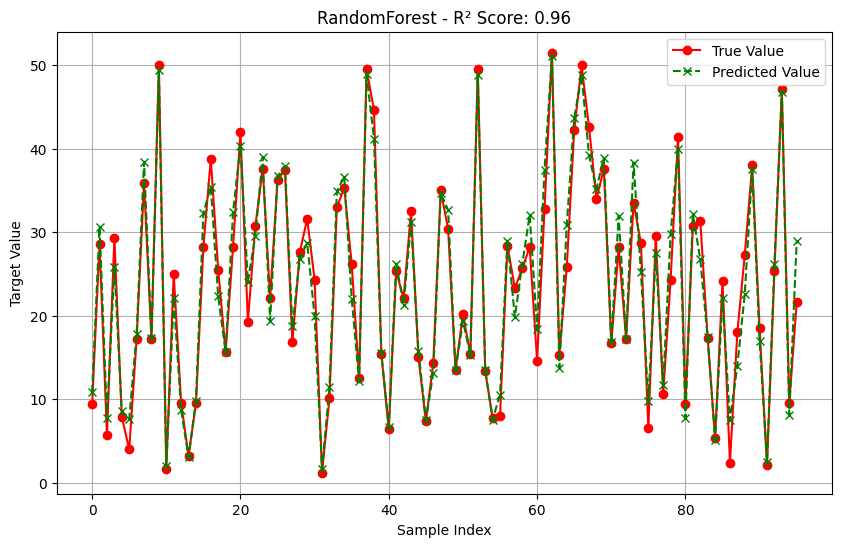

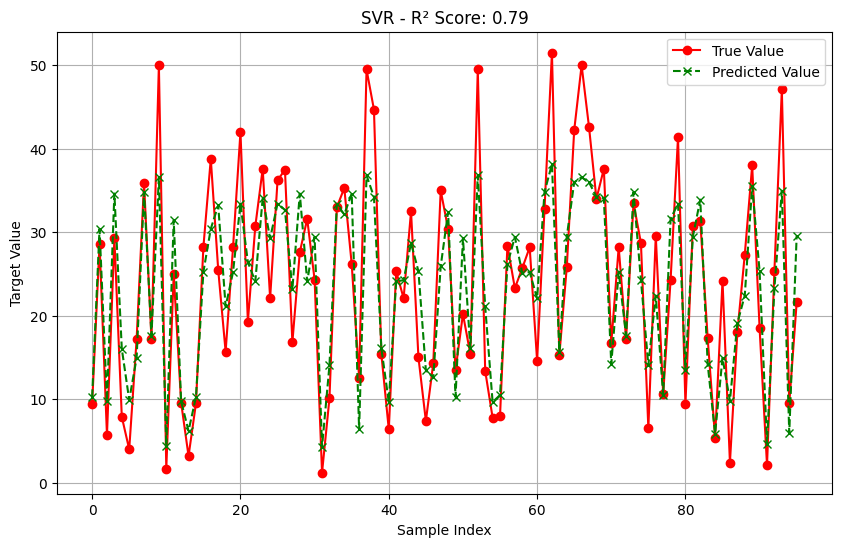

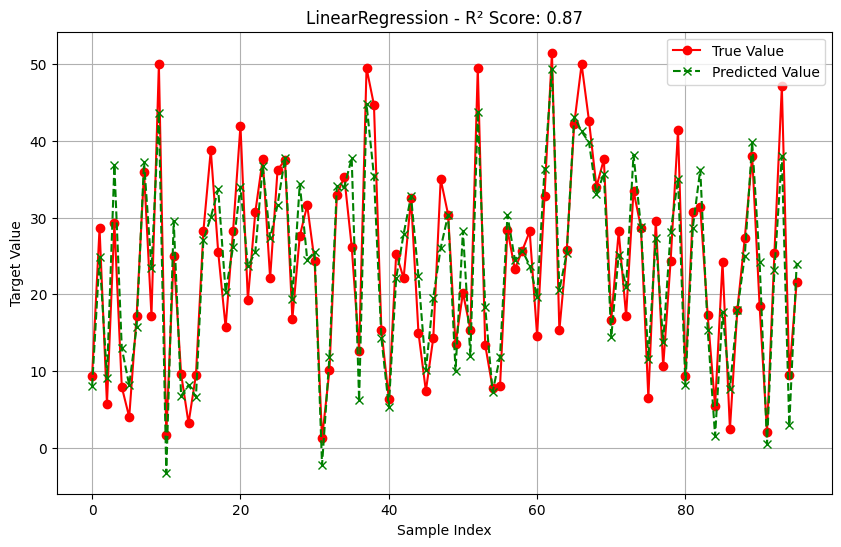

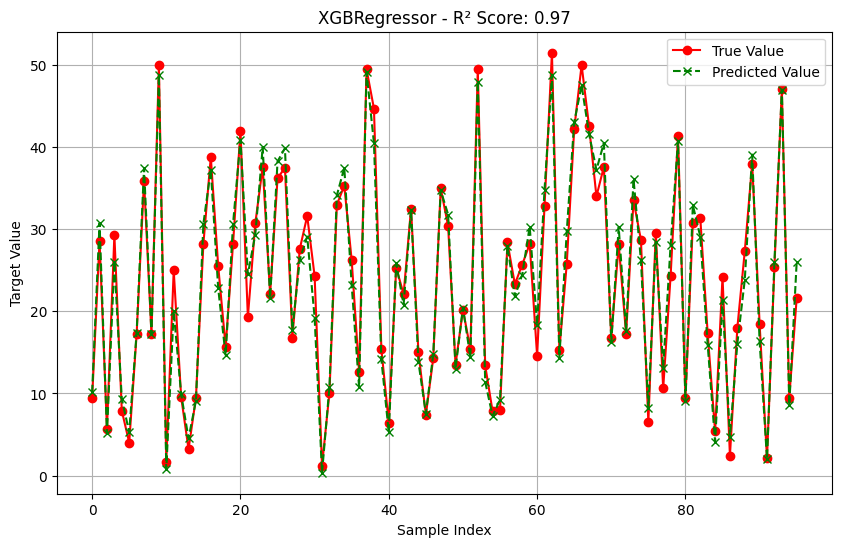

In [35]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 初始化一个字典来存储每个模型的预测值和真实值
model_predictions = {}
 
# 遍历模型，进行训练、预测，并收集预测值
for model_name, model in models.items():
    model.fit(X_train, y_train.values.ravel())  # 对于某些模型，y需要是一维数组
    y_pred = model.predict(X_test)
    model_predictions[model_name] = (y_test.values.ravel(), y_pred)
 
# 绘制每个模型的图像
for model_name, (y_true, y_pred) in model_predictions.items():
    r2 = r2_score(y_true, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_pred)), y_true, color="red", marker="o", label="True Value", linestyle="-")
    plt.plot(np.arange(len(y_pred)), y_pred, color="green", marker="x", label="Predicted Value", linestyle="--")
    plt.title(f"{model_name} - R² Score: {r2:.2f}")
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

**7 回归性能分析图**

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

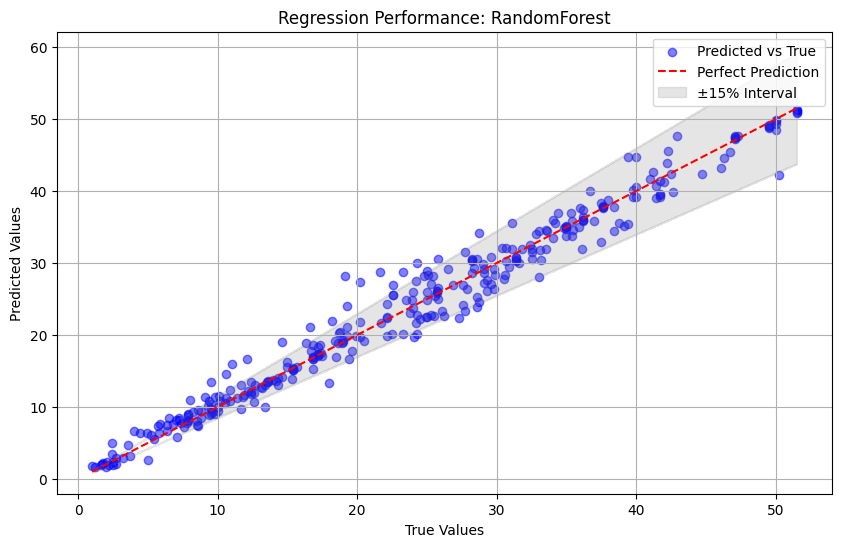

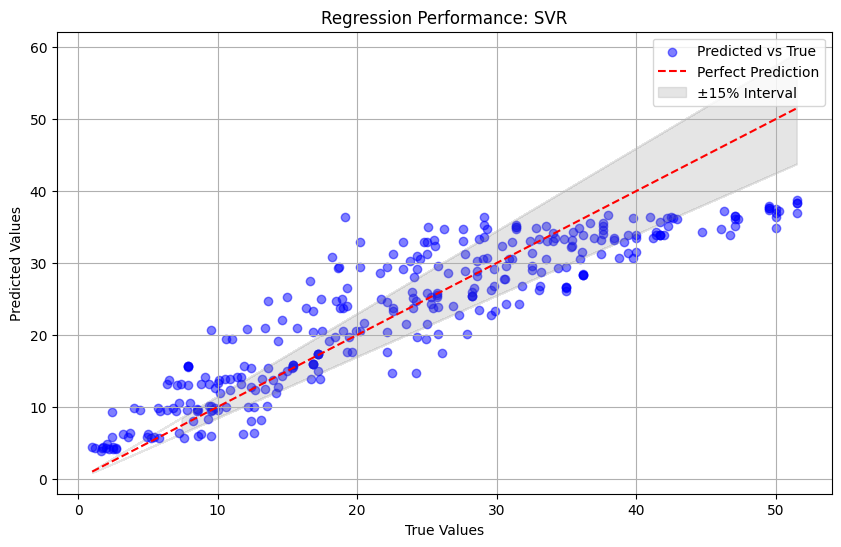

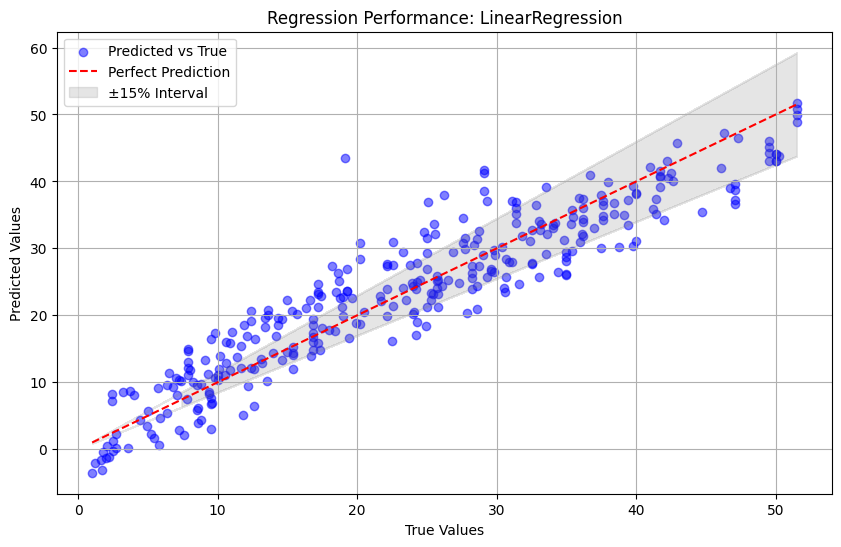

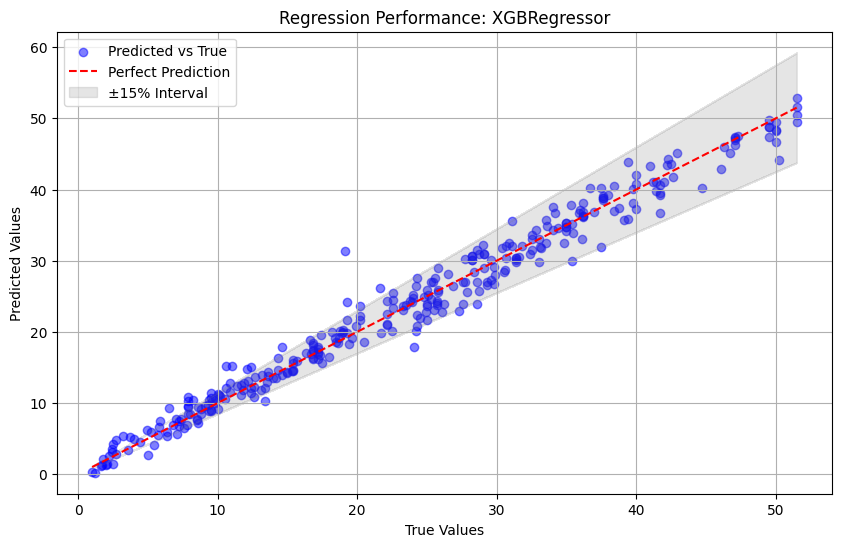

In [36]:
# 初始化一个字典来存储每个模型的预测值和真实值
model_predictions = {model_name: [] for model_name in models.keys()}
 
# 遍历模型，进行交叉验证，并收集预测值
for model_name, model in models.items():
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_test)
        
        # 存储预测值和真实值
        model_predictions[model_name].append((y_test.values.ravel(), y_pred))
 
# 绘制每个模型的回归性能对比图
for model_name, predictions in model_predictions.items():
    y_true_all = np.concatenate([p[0] for p in predictions])
    y_pred_all = np.concatenate([p[1] for p in predictions])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_all, y_pred_all, color="blue", marker="o", alpha=0.5, label="Predicted vs True")
    plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], color="red", linestyle="--", label="Perfect Prediction")
    
    # 计算正负15%区间
    lower_bound = y_true_all * 0.85
    upper_bound = y_true_all * 1.15
    plt.fill_between(y_true_all, lower_bound, upper_bound, color="gray", alpha=0.2, label="±15% Interval")
    
    plt.title(f"Regression Performance: {model_name}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

**8 跟上个图一样，不同画法**

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

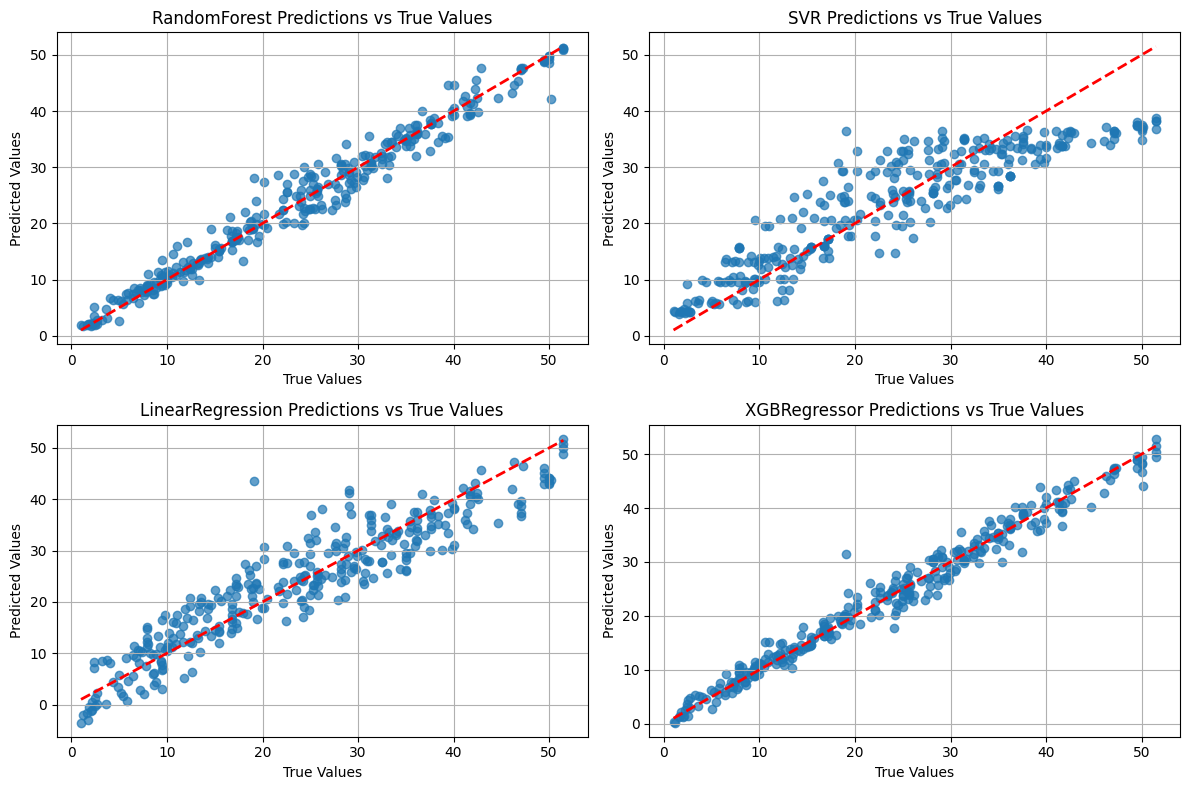

In [37]:
# 存储每个模型的预测值
predictions = {}
 
# 对每个模型进行交叉验证并存储预测值
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    predictions[model_name] = y_pred
 
# 绘制散点图
plt.figure(figsize=(12, 8))
for i, (model_name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(y, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)  # 45度线
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predictions vs True Values')
    plt.grid(True)
 
# 调整子图布局
plt.tight_layout()
 
# 显示图形
plt.show()

**9 真实值和预测值对比折线图**

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

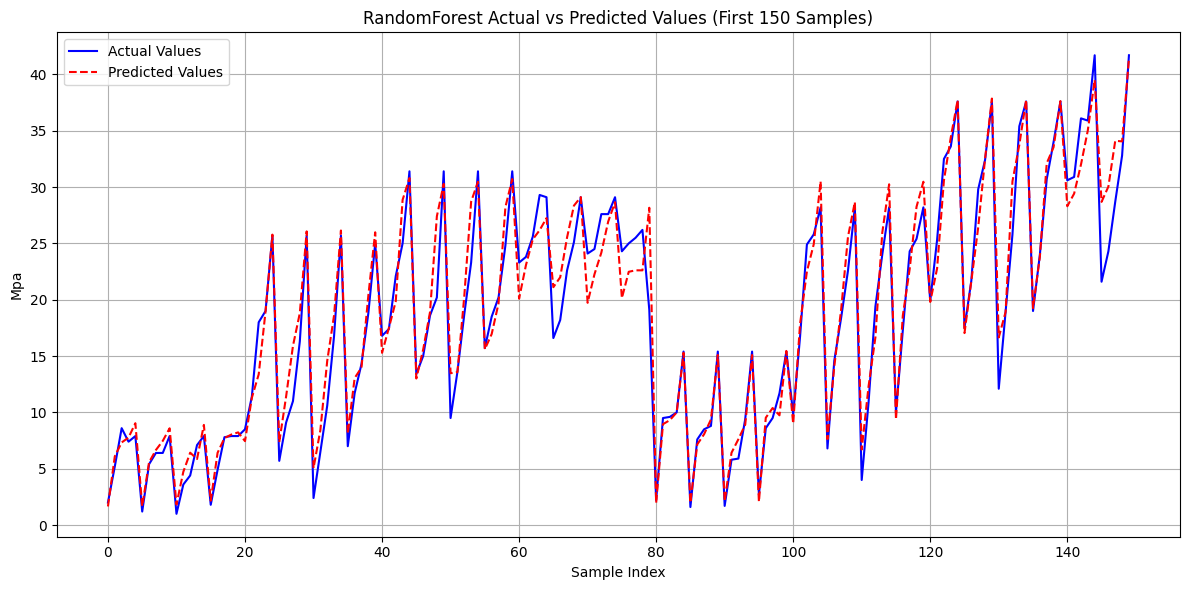

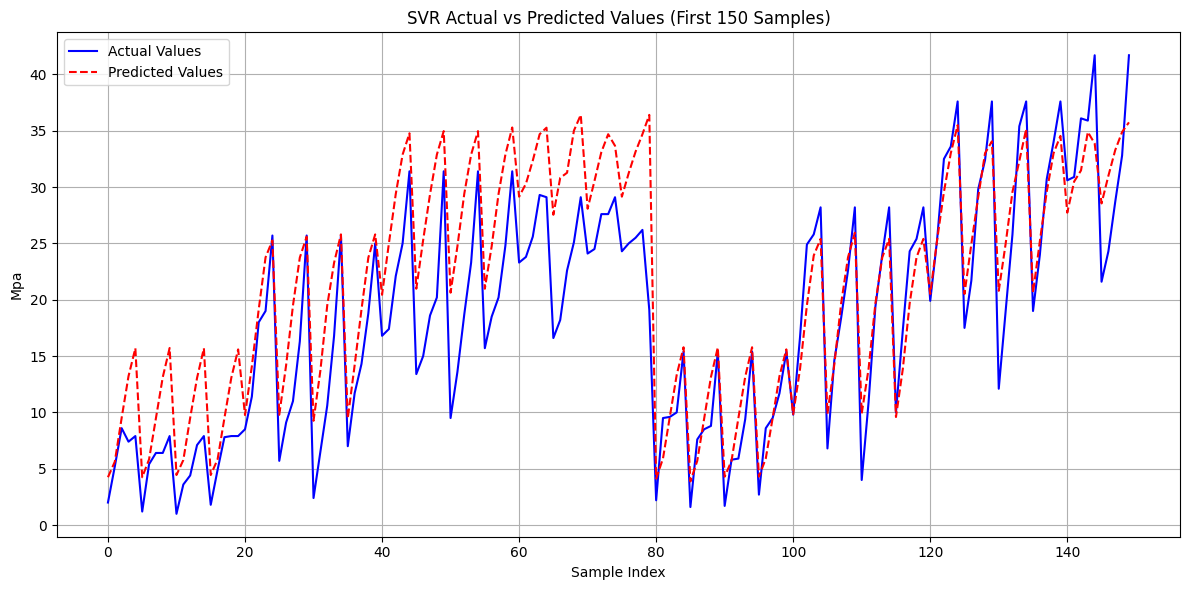

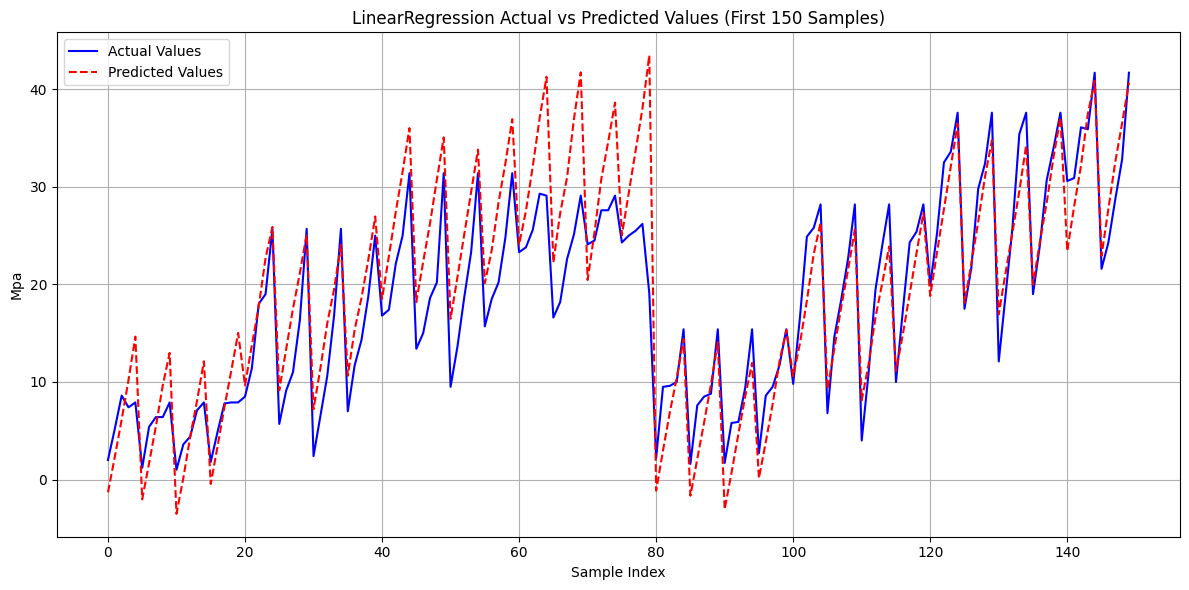

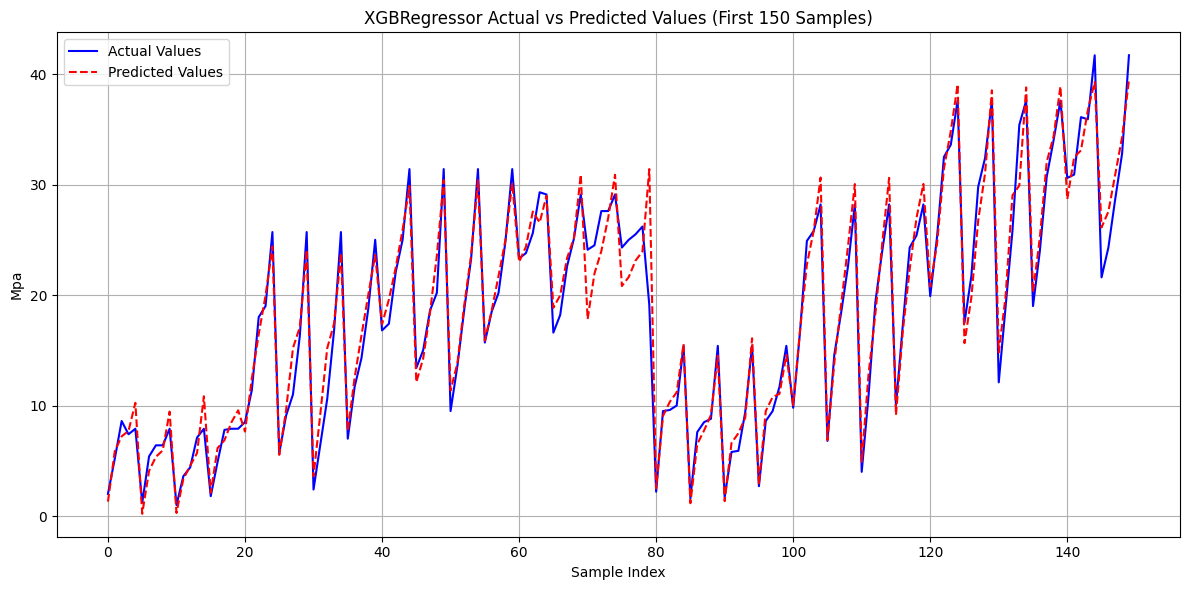

In [38]:
num_samples_to_plot = 150  # 要绘制的样本数量  
  
# 遍历模型，进行交叉验证并绘制图形  
for name, model in models.items():  
    # 交叉验证预测  
    y_pred = cross_val_predict(model, X, y, cv=kf)  
      
    # 确保有足够的样本可供绘制  
    if len(y) < num_samples_to_plot:  
        print(f"Warning: Not enough samples to plot {num_samples_to_plot} points for model {name}. Plotting all {len(y)} samples.")  
        num_samples_to_plot = len(y)  
      
    # 切片以只取前 num_samples_to_plot 个样本  
    y_true_slice = y[:num_samples_to_plot]  
    y_pred_slice = y_pred[:num_samples_to_plot]  
      
    # 绘制真实值和预测值的折线图  
    plt.figure(figsize=(12, 6))  
    plt.plot(y_true_slice, label='Actual Values', color='blue')  
    plt.plot(y_pred_slice, label='Predicted Values', color='red', linestyle='--')  
      
    plt.xlabel('Sample Index')  
    plt.ylabel('Mpa')  # 假设你的目标变量是以 Mpa 为单位的  
    plt.title(f'{name} Actual vs Predicted Values (First {num_samples_to_plot} Samples)')  
    plt.legend()  
    plt.grid(True)  
    plt.tight_layout()  
    plt.savefig(f'{name}_actual_vs_predicted_{num_samples_to_plot}_samples.png')  # 保存图像文件，包含样本数量信息  
    plt.show()

**接下来开始SHAP分析**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
# 训练 CatBoost 模型
XGBR = XGBRegressor(
        objective='reg:squarederror',  # 目标函数，这里是平方误差
        n_estimators=100,              # 树的数量
        learning_rate=0.1,             # 学习率
        max_depth=3,                   # 树的最大深度
        min_child_weight=1,            # 叶子节点最小权重和
        subsample=0.8,                 # 子样本比例
        colsample_bytree=0.8,          # 每棵树随机采样特征的比例
        gamma=0,                       # 损失函数减少的最小值
        reg_alpha=0,                   # L1正则化项
        reg_lambda=1,                  # L2正则化项
        random_state=42                # 随机数生成器的种子
    )
XGBR.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# 解释器
explainer = shap.TreeExplainer(XGBR)

In [10]:
#计算两个核心值
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

**将上述功能定义为一个函数**

In [15]:
"""
    检索指定样本的特征、真实值、预测值以及SHAP值。
    
    参数:
    sample_index (int): 样本索引（从0开始）
    
    返回:
    dict: 包含样本特征、真实值、预测值和SHAP值的字典
    """

def get_sample_info(sample_index):
    
    # 检索样本特征
    sample_features = X_test.iloc[sample_index]
    
    # 检索样本真实值
    sample_true_value = y_test.iloc[sample_index]
    
    # 预测样本值
    sample_pre_value = XGBR.predict([sample_features])[0]
    
    # 检索样本的SHAP值
    sample_shap_values = shap_values[sample_index]
    
    # 返回包含所有信息的字典
    return {
        "【features】": sample_features,
        "【true_value】": sample_true_value,
        "【predicted_value】": sample_pre_value,
        "【shap_values】": sample_shap_values
    }


In [16]:
get_sample_info(16)

{'【features】': Cmcent    489.0
 Cr         80.0
 Me          0.0
 Ei          0.0
 Ai         73.0
 Ac          0.1
 Li         36.5
 Gy         12.0
 Ct          3.0
 Name: 75, dtype: float64,
 '【true_value】': Mpa    24.3
 Name: 75, dtype: float64,
 '【predicted_value】': 22.965988,
 '【shap_values】': .values =
 array([ 3.9664173 ,  1.256216  , -1.2701073 , -0.92404824,  2.740876  ,
         1.3250523 ,  0.05188375,  0.        , -7.6571684 ], dtype=float32)
 
 .base_values =
 23.47687
 
 .data =
 array([4.89e+02, 8.00e+01, 0.00e+00, 0.00e+00, 7.30e+01, 1.00e-01,
        3.65e+01, 1.20e+01, 3.00e+00])}

**打印各种可视化图例**

In [ ]:
"""
base_values = 23.47687 是模型不考虑任何特征影响时的输出值，通过不同特征的影响，最终的预测值为18.35
也就是说：base_values + shap_values = predicted_value,
['2.98', '0.62', '0.32', '-0.91', '2.07', '-1.73', '-0.01', '0.00', '-8.47']
"""

In [56]:
shap.plots.force(shap_values[16,...]) 

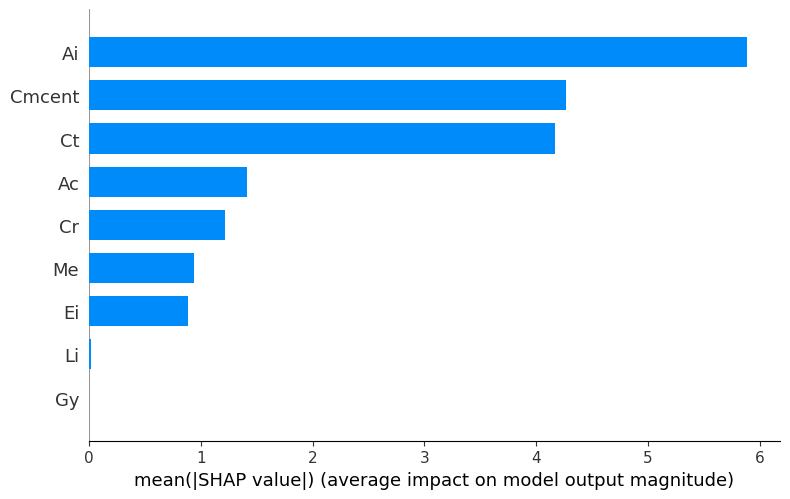

In [51]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

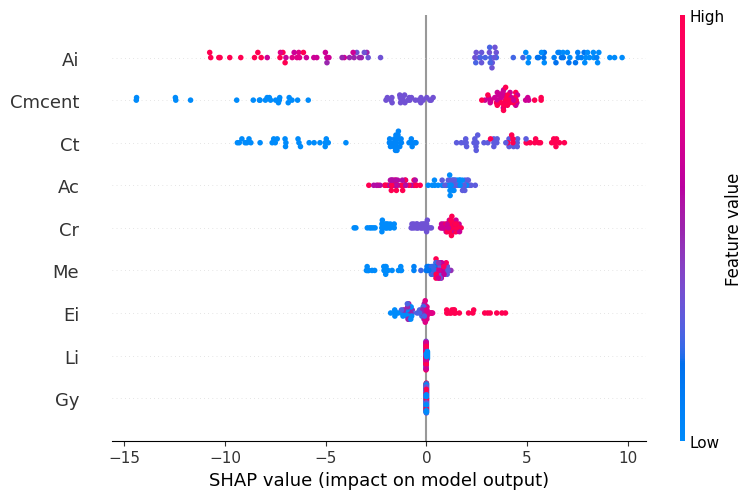

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

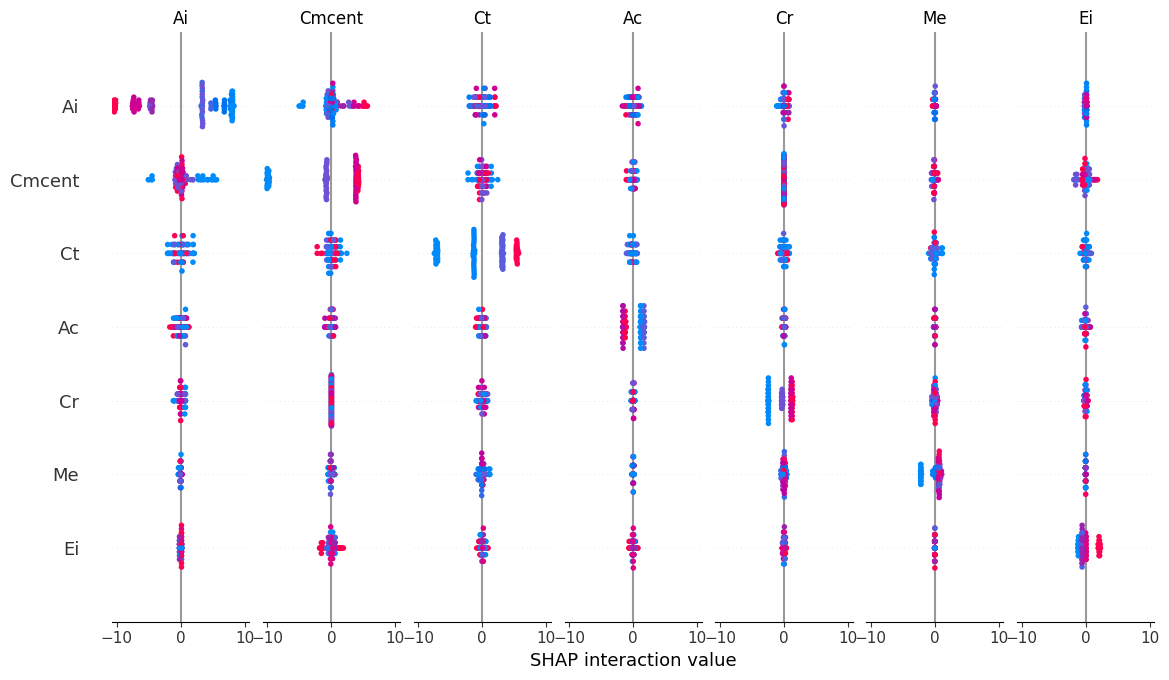

In [53]:
shap.summary_plot(shap_interaction_values, X_test)

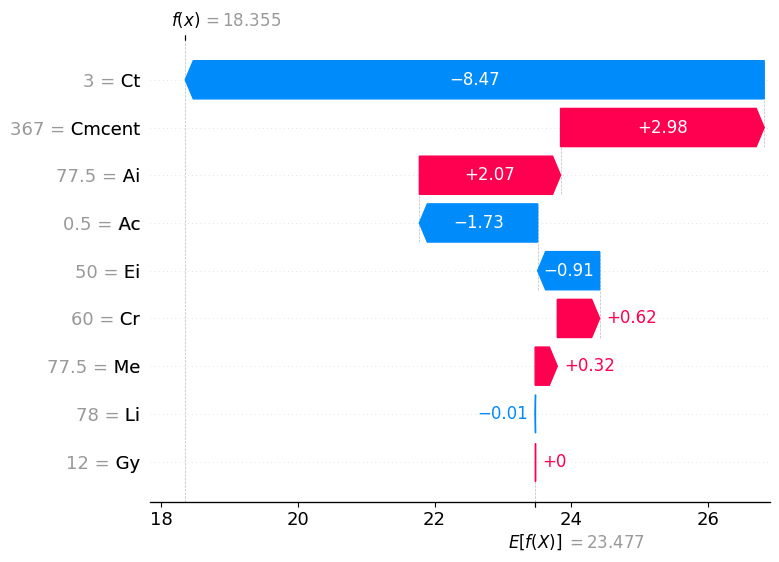

In [55]:
shap.plots.waterfall(shap_values[16])